In [8]:
from obspy.core import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
%matplotlib inline
from scipy import signal

from obspy import UTCDateTime
from obspy import Stream

import sys
import os

# from scipy.integrate import simps

# sys.path.append('/Users/ab14785/OneDrive - University of Bristol/1-Coding/x-reference_code')

# import ant_functions as ant

In [11]:
from ISpy.detect import trigger
from ISpy.utils import utils
from obspy.core import read

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read In data

In [69]:
stations=['PNR01','PNR02','PNR3A','PNR3B','PNR04','PNR05','PNR06','PNR07']
channels=['HHE','HHN','HHZ']
filename='data/2019-08-23-2220-39S.BLAC__069'

st=utils.data_in(filename,stations,channels,plot=True)

## Checking trigger

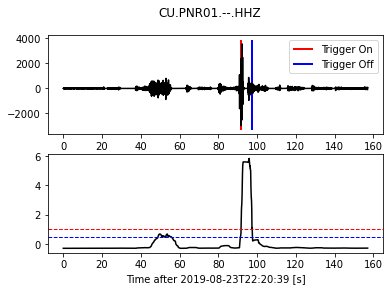

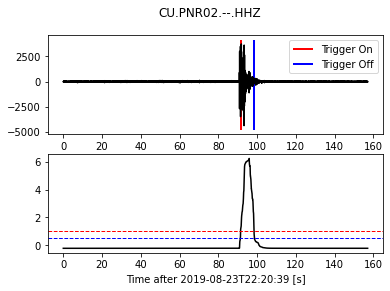

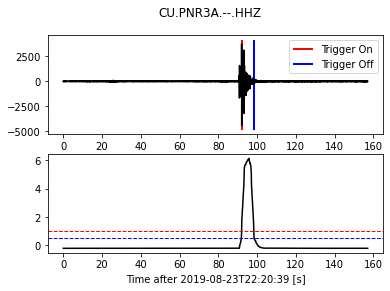

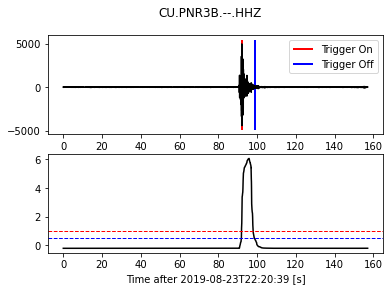

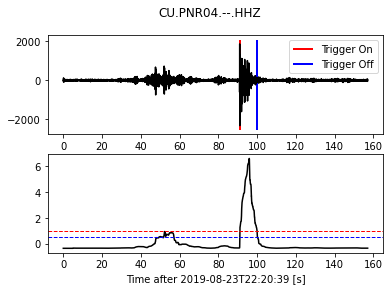

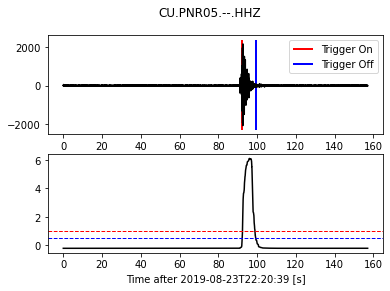

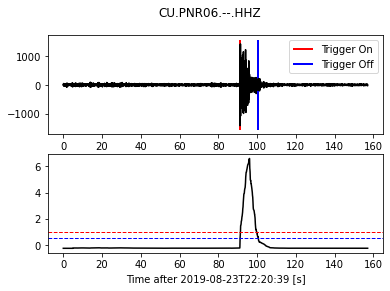

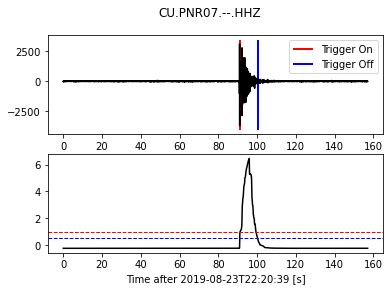

In [73]:
trigger.trigger_check(st,station='PNR*',channel='HHZ',on=1,off=0.5,window=5)

## Coincidence trigger

In [ ]:
trigger.iscoincidence(st,stations,channel='HHE',on=1,off=0.5,minsta=3,window=5)

In [ ]:
sac="printf \"m pick.mac 20190823222210 PNR06 \"| sac > sac.log"
os.system(sac)

In [ ]:
stations=['PNR01','PNR02','PNR3A','PNR3B','PNR04','PNR05','PNR06','PNR07']

In [159]:
for tr in st:
    print(tr.stats.station)

PNR01
PNR01
PNR01
PNR02
PNR02
PNR02
PNR04
PNR04
PNR04
PNR05
PNR05
PNR05
PNR06
PNR06
PNR06
PNR07
PNR07
PNR07
PNR3A
PNR3A
PNR3A
PNR3B
PNR3B
PNR3B


## Create coincidence filter

In [161]:
st2=st.copy()
st2=st2.select(channel='HHE')
# trig=coincidence_trigger('recstalta',5,0.5,st2,3,sta=1,lta=10)
trig=coincidence_trigger('zdetect',1,0.5,st2,3,details=True,nsta=int(5*df))

In [162]:
trig_pd=pd.DataFrame(trig)
trig_pd

,time,stations,trace_ids,coincidence_sum,similarity,cft_peaks,cft_stds,duration,cft_peak_wmean,cft_std_wmean
0,2019-08-23T22:22:10.410000Z,"[PNR3B, PNR3A, PNR02, PNR06, PNR07, PNR01, PNR...","[CU.PNR3B.--.HHE, CU.PNR3A.--.HHE, CU.PNR02.--...",8.0,{},"[5.77821550565, 5.80954482569, 5.74728616344, ...","[1.4593125756, 1.56285830766, 1.52245548045, 1...",7.675,5.899249,1.605506


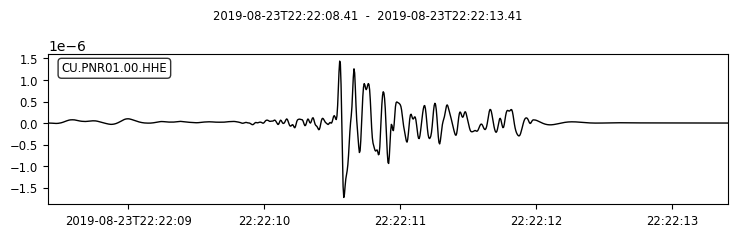

         network: CU
         station: PNR01
        location: 00
         channel: HHE
       starttime: 2019-08-23T22:22:08.410000Z
         endtime: 2019-08-23T22:22:13.410000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 1001
           calib: 1.0
         _format: SAC
             sac: AttribDict({'delta': 0.0049999999, 'depmin': -1.7286558e-06, 'depmax': 1.4390677e-06, 'scale': 1.0, 'b': 0.0, 'e': 5.0, 'a': 1.4359099, 't0': 2.1600001, 'depmen': 1.3897143e-08, 'nzyear': 2019, 'nzjday': 235, 'nzhour': 22, 'nzmin': 22, 'nzsec': 8, 'nzmsec': 410, 'nvhdr': 6, 'npts': 1001, 'iftype': 1, 'iztype': 9, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'kstnm': 'PNR01', 'khole': '00', 'ka': 'IPU0', 'kcmpnm': 'HHE', 'knetwk': 'CU'})

In [241]:
st4=read("%s%s"%(sacpath,'CU.PNR01.20190823222210.HHE.sac'))
st4.plot()
st4[0].stats

In [243]:
# stations=['PNR01','PNR02','PNR3A','PNR3B','PNR04','PNR05','PNR06','PNR07']

stations=['PNR01']

stime=st[0].stats.starttime

if len(trig_pd)>0:

    ttime=trig_pd.time[0]
    
    id=('%04d%02d%02d%02d%02d%02d'%(ttime.year,ttime.month,ttime.day,ttime.hour,ttime.minute,ttime.second))
    print(id)
    for station in stations:
        for channel in ('HHE','HHN','HHZ'):
            # Select the trace
            st2=st.copy()
            st2=st2.select(station=station)
            st2=st2.select(channel=channel)
           
            # Apply stalta to trace to identify pick times
            cft=z_detect(st2[0].data,int(5*df))
            list=trigger_onset(cft,0.3,0.2)
            onset_time=stime+list[0][0]/df
#             plot_trigger(st2[0],cft,1,0.5)

            # Slice the data in 5 second files
            st3=st2.copy()
            st3=st3.slice(ttime-2,ttime+3)
                      
            # Save SAC file
            sacpath='data/%s/SAC/'%(id)
            file=tr_write(st3[0],sacpath,id,resp=True,freqmin=0.01,freqmax=50)
            print(file)
            
            imgpath='data/%s/img/'%(id)
            if not os.path.exists(imgpath):
                os.makedirs(imgpath)
            
            fig=plt.figure(figsize=[10,3])
            plt.title('%s - %s'%(st3[0].stats.starttime,st3[0].stats.endtime))
            plt.plot(st3[0].times(),st3[0].data,'k')
            plt.axvline(x=onset_time-(ttime-2),color='r')
            plt.xlim(0,5)
            plt.xlabel('Time (s)')
            plt.savefig("%s%s.png"%(imgpath,file))
            plt.close(fig)
#             plt.show()
    
            # Read in again to include pick times
            st4=read("%s%s"%(sacpath,file))
            print(onset_time-(ttime-2))
            
            if channel=='HHZ':
                st4[0].stats.sac['ka']='IPU0'
                st4[0].stats.sac['a']=onset_time-(ttime-2)
                
            else:
                st4[0].stats.sac['kt0']='ISU0'
                st4[0].stats.sac['t0']=onset_time-(ttime-2)
                
            file=tr_write(st4[0],sacpath,id,resp=False,freqmin=0.01,freqmax=50)
#             st4.plot()
            
    

20190823222210
data/20190823222210/SAC/CU.PNR01.20190823222210.HHE.sac
CU.PNR01.20190823222210.HHE.sac
2.16
data/20190823222210/SAC/CU.PNR01.20190823222210.HHE.sac
data/20190823222210/SAC/CU.PNR01.20190823222210.HHN.sac
CU.PNR01.20190823222210.HHN.sac
2.145
data/20190823222210/SAC/CU.PNR01.20190823222210.HHN.sac
data/20190823222210/SAC/CU.PNR01.20190823222210.HHZ.sac
CU.PNR01.20190823222210.HHZ.sac
1.565
data/20190823222210/SAC/CU.PNR01.20190823222210.HHZ.sac


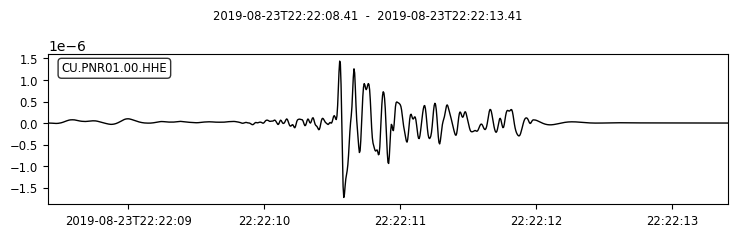

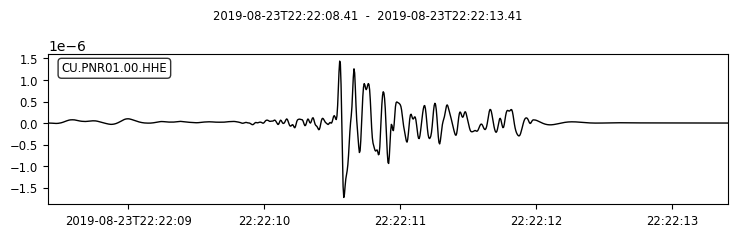

In [193]:
test=read('data/20190823222210/SAC/CU.PNR01.20190823222210.HHE.sac')
test.plot()

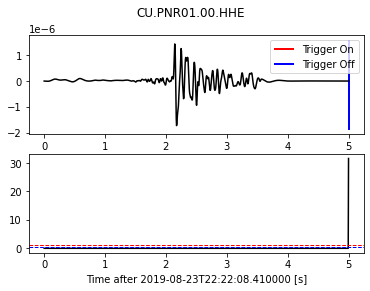

In [194]:
cft=z_detect(test[0].data,int(5*df))
plot_trigger(test[0],cft,1,0.5)

In [140]:
print(trig_pd.time[0]-st2[0].stats.starttime)

91.41


(85.0, 95.0)

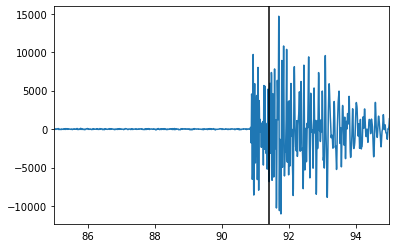

In [147]:
plt.plot(st2[5].times(),st2[5].data)
plt.axvline(x=trig_pd.time[0]-st2[0].stats.starttime,color='k')
plt.xlim(85,95)

In [157]:
print(np.max([trig_pd.time[0],trig_pd.time[0]+6]))

2019-08-23T22:22:16.410000Z


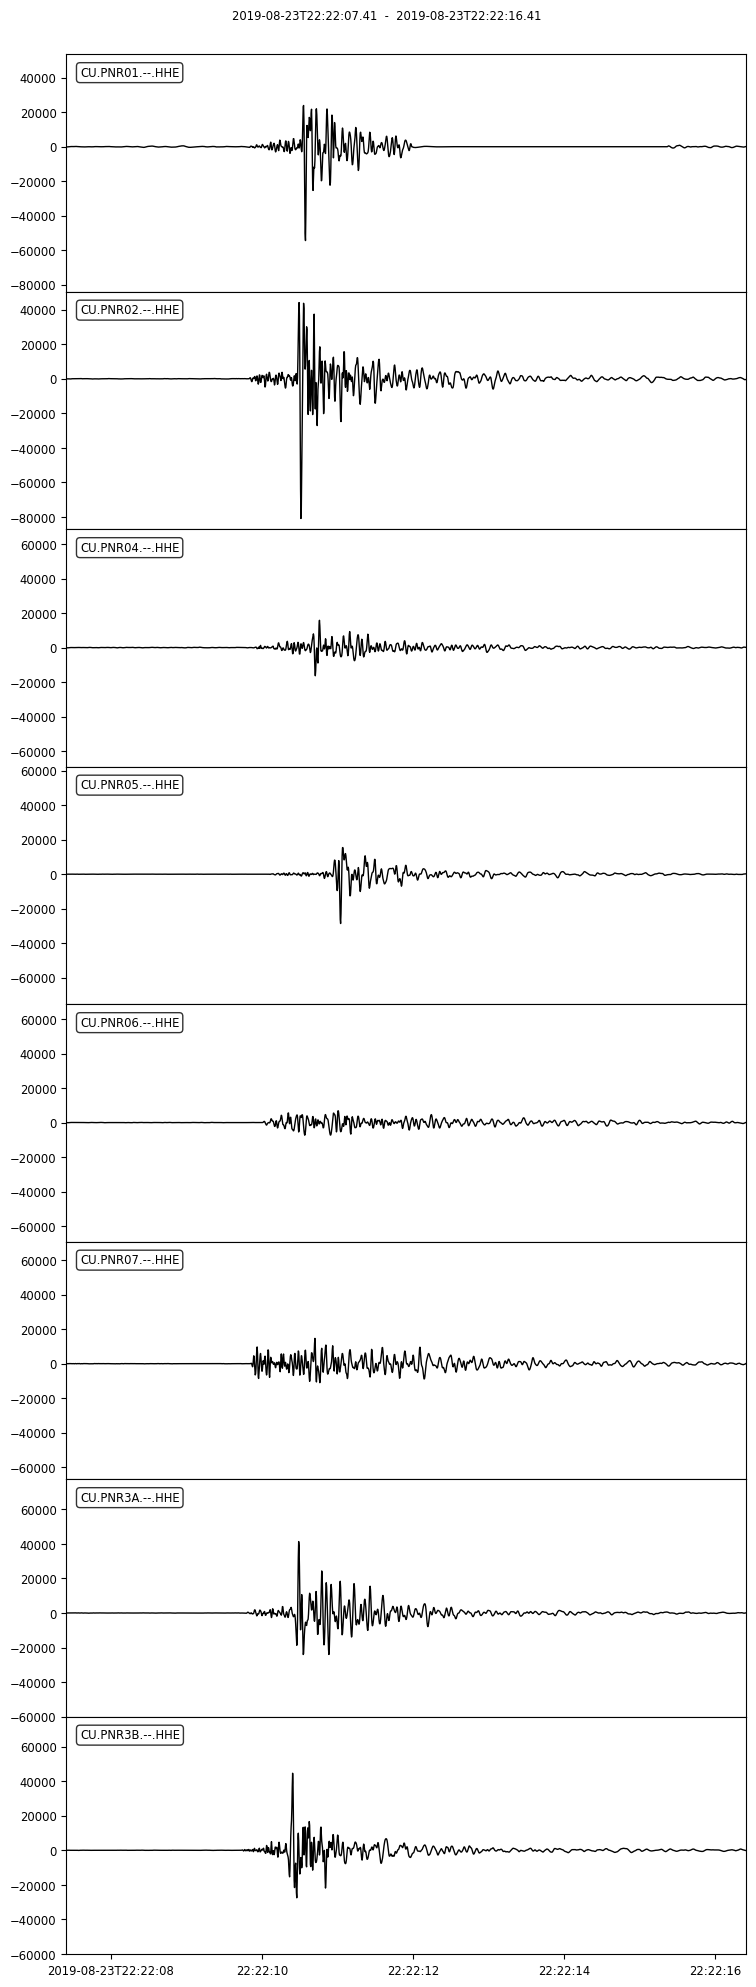

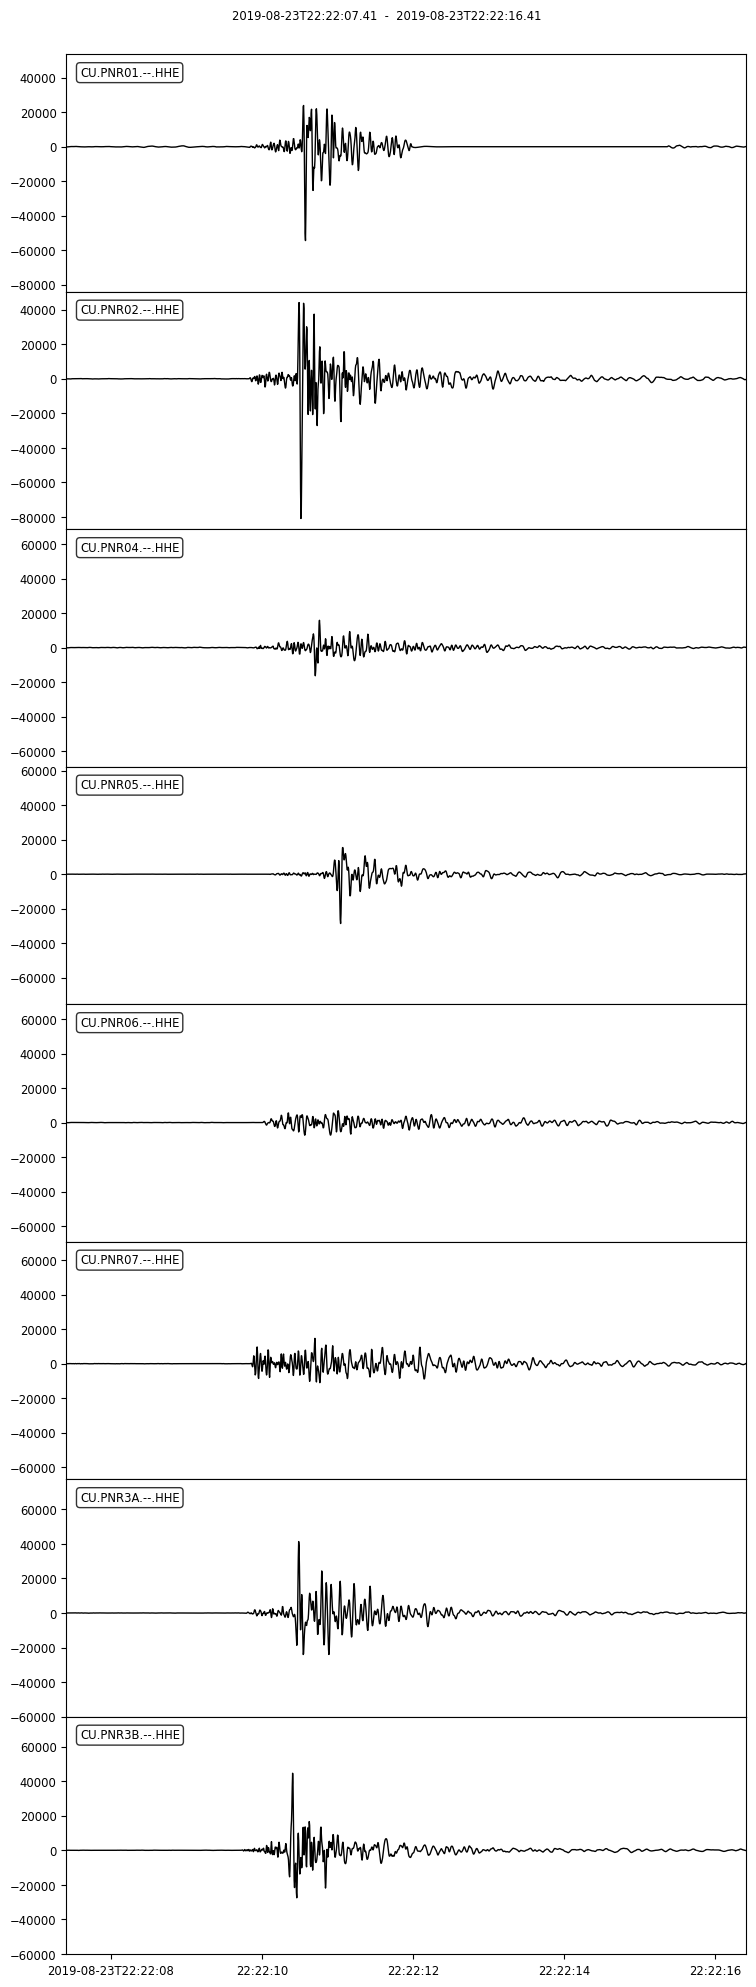

In [142]:
st2.plot(starttime=trig_pd.time[0]-3,endtime=trig_pd.time[0]+6)
# plt.axvline()